# Population vector analysis 

'''Created on Tue 27 April 2021'''

In this notebook we will analyze the population vector for different behaviours for all mice using the ethogram information that was extracted from DLC for once the mouse in one sessions.

Categories for different behaviours are: resting, navigation, exploring object (1 or 2) and running towards object (1 or 2). 

The experiment runs in multiple days, and we will like to see the effect of learning in the population vector for the above mentioned behaviours. Differences in population vectors will, a priori, be analyzed be computing the euclidian distance between those vectors. (THINK ABOUT HOW TO COMPARE FOR DIFFERENT DAYS AS DIFFERENT DAYS HAS DIFFERENT SIZE OF POP VECTOR)

In [5]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
#import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [6]:
mouse_vector = [32363, 32364, 32365,56165]
conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
sessions_random = [1,0,2,0]
sessions_overlapping = [2,1,0,1]
sessions_stable = [0,2,0,0]
fixed_object_id = [6,4,0,5]


sessions = [sessions_random, sessions_overlapping, sessions_stable]
colapse = [0,1,2]

decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 3           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 0        ## registration version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                ## value of resampling
period = int(1 * sf / re_sf)
period_resting = period *10

print(sessions)

[[1, 0, 2, 0], [2, 1, 0, 1], [0, 2, 0, 0]]


In [7]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
#behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
#behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [8]:
distance_list = []   ## correlation matrix list that will contain all the correlation matrix of multiple mice
distance_list_z = []
for session_type in range(len(sessions)):
    session_numbers = sessions[session_type]
    colapse_behaviour = colapse[session_type]
    distance_list_mouse = []
    distance_list_mouse_z = []
    for mouse_number in range(len(mouse_vector)):
        object_fixed = fixed_object_id[mouse_number]
        mouse = mouse_vector[mouse_number]
        session = session_numbers[mouse_number]
        if session != 0:
            activity_list = []
            timeline_list = []
            behaviour_list = []
            day = 1
            for trial in [1,6,11,16]:
                file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                                      f'{component_evaluation_v}' +  '.0.npy'

                ##load activity and timeline
                activity = np.load(file_directory + file_name_session_1)
                neural_activity1 = activity[1:,:]
                ## z-score neural activity
                neural_activity = sstats.zscore(neural_activity1)

                ##downsample neural activity
                resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                                    re_sf=re_sf)

                activity_list.append(resample_neural_activity_mean)

                time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                                      '.' + f'{0}' + '_10.pkl'
                timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
                timeline_info = pickle.load(timeline_file)
                ##normalize neural activity
                timeline_1 = np.zeros(len(timeline_info) + 1)
                for i in range(len(timeline_info)):
                    timeline_1[i] = timeline_info[i][1]
                timeline_1[len(timeline_info)] = activity.shape[1]
                resample_timeline = timeline_1/re_sf

                timeline_list.append(resample_timeline)

                #beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
                behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session}' + '/'
                beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_likelihood_0.75_ethogram.npy'
                ## LOAD BEHAVIOUR
                behaviour = np.load(behaviour_dir + beh_file_name_1)
                #c = np.linspace(0, 20, len(behaviour))
                reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
                resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
                resample_timeline = timeline_1/re_sf

                behaviour_list.append(resample_beh1)
                day = day + 1
            # for each day creates a list that counts and saves times of different events.
            # We will consider events here as resting period, navigation periods and object exploration periods.
            # Later on will also consider different objects in the exploration periods

            id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
            if colapse_behaviour == 0 : # RANDOM
                for day in range(len(behaviour_list)):
                    for trial in range(5):
                        behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                        objects = np.unique(behaviour_trial)
                        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                        index0 = np.where(behaviour_trial==objects[selected_object])[0]
                        index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                        index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                        behaviour_trial[index0] = 3
                        behaviour_trial[index1] = 4
                        behaviour_trial[index2] = 4            

                        index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                        index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                        index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                        behaviour_trial[index0] = 5
                        behaviour_trial[index1] = 6
                        behaviour_trial[index2] = 6 

                        behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


            if colapse_behaviour == 1 : #OVERLAPPING
                for day in range(len(behaviour_list)):
                    behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
                    behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
                    behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
                    behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
                    behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
                    behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


            if colapse_behaviour == 2: #STABLE
                for day in range(len(behaviour_list)):
                    objects = np.unique(behaviour_list[day])
                    selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                    index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
                    index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
                    index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
                    behaviour_list[day][index0] = 3
                    behaviour_list[day][index1] = 4
                    behaviour_list[day][index2] = 4      

                    index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
                    index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
                    index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
                    behaviour_list[day][index0] = 5
                    behaviour_list[day][index1] = 6
                    behaviour_list[day][index2] = 6 
            
            events_day_list = []
            events_counter_day_list = []
            events_time_starts_day = []
            for day in range(len(behaviour_list)):
                events_list = []
                events_counter_list = []
                events_time_starts = []
                start_counter = 100
                counter = 0
                for i in range(behaviour_list[day].shape[0]):
                    if behaviour_list[day][i] != start_counter:
                        events_list.append(start_counter)
                        events_counter_list.append(counter)
                        events_time_starts.append(i)
                        start_counter = behaviour_list[day][i]
                        counter = 1
                    else:
                        counter = counter + 1
                events_day_list.append(events_list)
                events_counter_day_list.append(events_counter_list)
                events_time_starts_day.append(events_time_starts)

            # separte events belonging to each of the behavioural conditions

            behavioural_events_days_list = []
            for day in range(len(behaviour_list)):
                events = np.array(events_day_list[day])
                #events[np.where(events>1)] = 2
                events_counter = np.array(events_counter_day_list[day])
                events_time = np.array(events_time_starts_day[day])

                object_list = []
                for target in [0,1,2,3,4,5,6]:
                    period1 = period
                    if target == 0:
                        period1 = period_resting
                    object_data = []
                    position_events = np.where(events == target)[0]
                    events_duration = events_counter[position_events]   # convert to seconds
                    time = events_time[position_events]
                    i = 0
                    for event in events_duration:
                        if event > period:
                            object_data.append(activity_list[day][:,time[i]:time[i]+period1])
                        i = i + 1
                    object_list.append(object_data)
                behavioural_events_days_list.append(object_list)

            population_vector = []
            for day in range(len(behaviour_list)):
                mean_over_trials_list = []
                for i in range(len(behavioural_events_days_list[day])):
                    mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
                    if mean_over_trials.shape:
                        mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
                population_vector.append(mean_over_trials_list)

            ## compute null hypotesis for euclidean distance

            # we compute for each day a matrix containing all the activity
            #matrix = []
            #matrix_elements_size= []
            #for day in range(len(behavioural_events_days_list)):
            #    matrix_list = []
            #    matrix_size = 0
            #    matrix_limits = []
            #    for i in range(len(behavioural_events_days_list[day])):
            #        if behavioural_events_days_list[day][i]: 
            #            period1 = period
            #            if i == 0:
            #                period1=period_resting
            #            mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)            
            #            matrix1 = np.zeros((len(mean_over_trials),period1*len(behavioural_events_days_list[day][i])))
            #            for j in range(len(behavioural_events_days_list[day][i])):
            #                matrix1[:,j*period1:(j+1)*period1] = behavioural_events_days_list[day][i][j]
            #            matrix_list.append(matrix1)
            #            matrix_limits.append([matrix_size, matrix_size + period1*len(behavioural_events_days_list[day][i])])
            #            matrix_size = matrix_size + period*len(behavioural_events_days_list[day][i])
            #    auxiliar_matrix = np.zeros((len(mean_over_trials),matrix_size))
            #    for i in range(len(matrix_list)):
            #        auxiliar_matrix[:,matrix_limits[i][0]:matrix_limits[i][1]] = matrix_list[i]
            #    matrix.append(auxiliar_matrix)
            #    matrix_elements_size.append(matrix_limits)

            ## compute euclidean distance matrix using normalization
            euclidean_distance_list = []
            euclidean_distance_list_z = []
            for day in range(len(behaviour_list)):
                euclidean_distance = np.zeros((len(population_vector[day]),len(population_vector[day])))
                for i in range(len(population_vector[day])):
                    for j in range(len(population_vector[day])):
                        distance = np.linalg.norm(population_vector[day][i]-population_vector[day][j])
                        euclidean_distance[i,j]= distance/ population_vector[day][i].shape
                    distance_mean = np.mean(euclidean_distance[np.triu_indices_from(euclidean_distance, k=1)])
                    distance_std = np.std(euclidean_distance[np.triu_indices_from(euclidean_distance, k=1)])
                    euclidean_distance_z_score =(euclidean_distance - distance_mean) / distance_std
                
                euclidean_distance_list_z.append(euclidean_distance_z_score)
                euclidean_distance_list.append(euclidean_distance)
            distance_list_mouse.append(euclidean_distance_list)
            distance_list_mouse_z.append(euclidean_distance_list_z)
    distance_list.append(distance_list_mouse)
    distance_list_z.append(distance_list_mouse_z)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


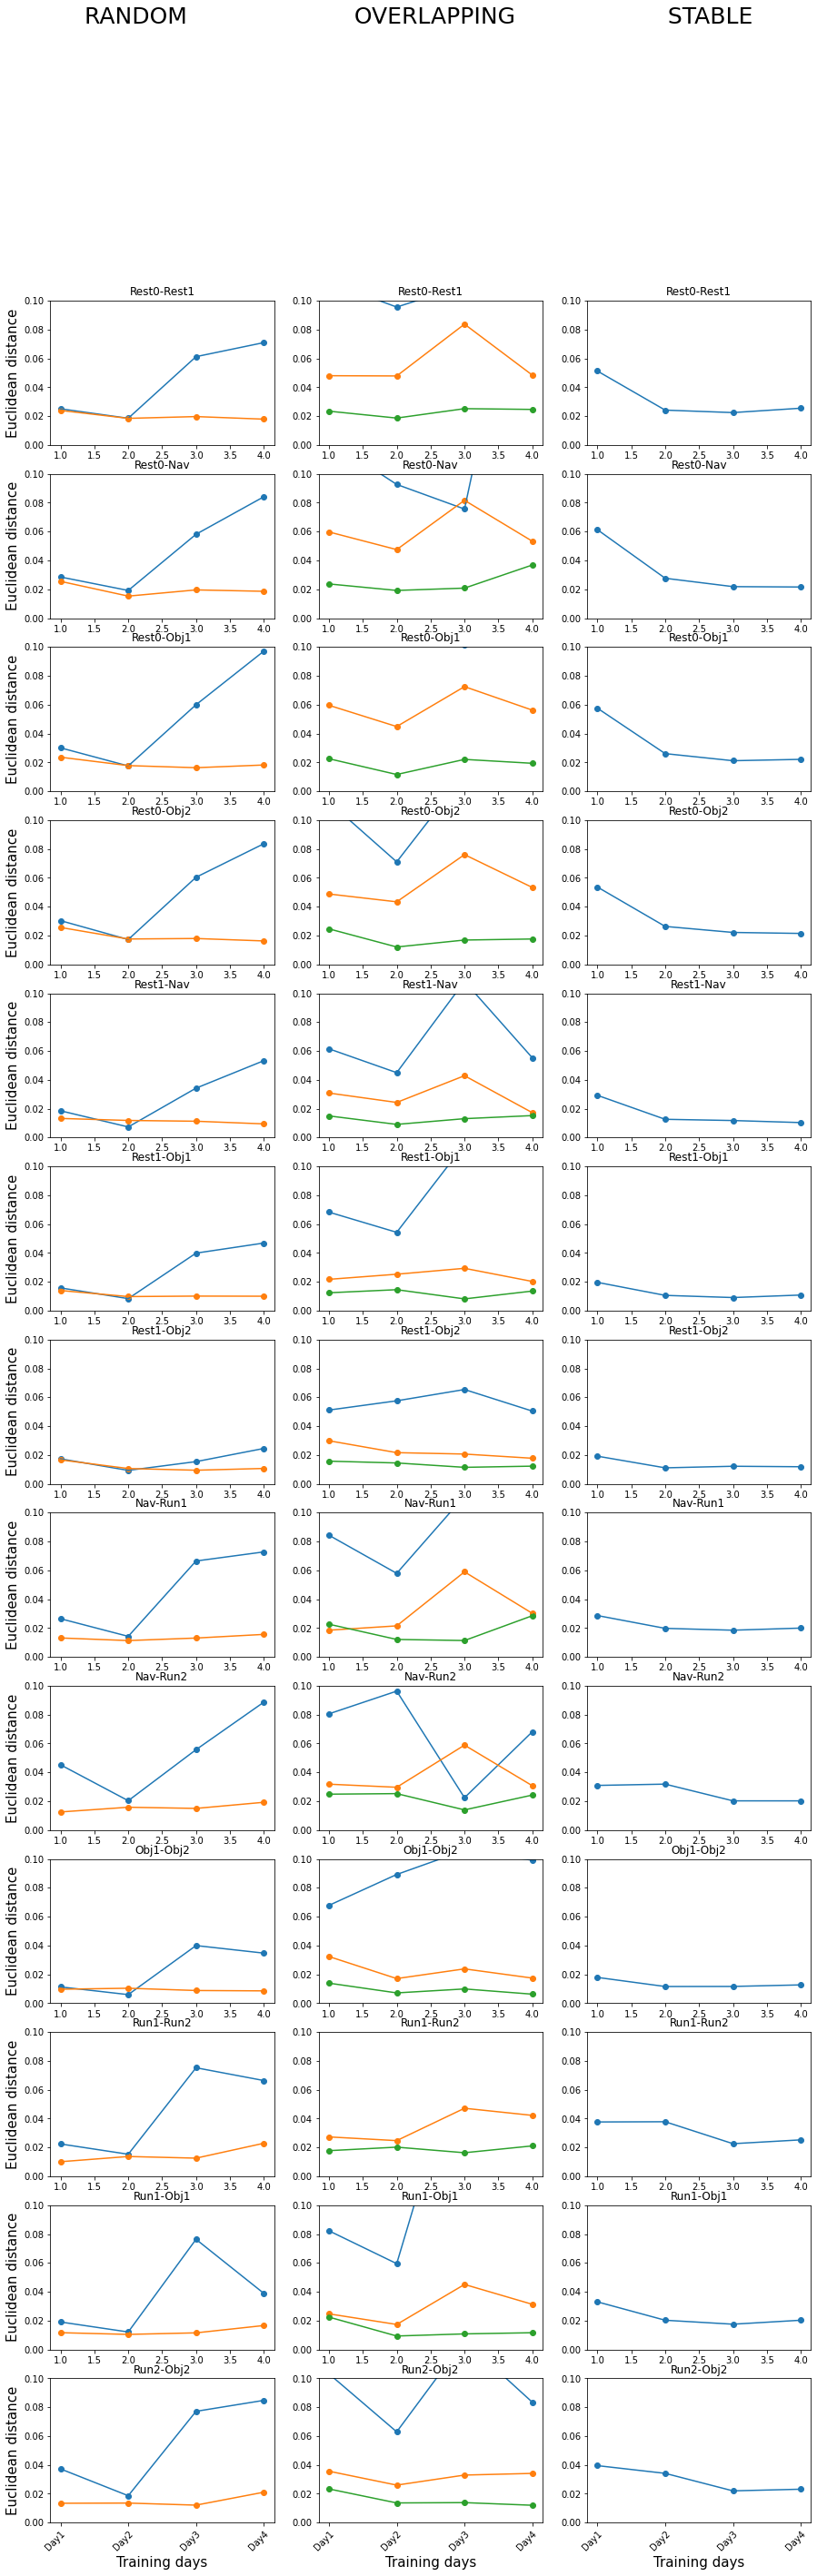

In [12]:
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(13,3)
labels = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2',
          'Rest1-Nav','Rest1-Obj1','Rest1-Obj2','Nav-Run1', 'Nav-Run2','Obj1-Obj2',
          'Run1-Run2','Run1-Obj1','Run2-Obj2']

evolution_list = []
for condition in range(3):
    for mouse in range(len(distance_list[condition])):
        evolution = np.zeros((4,13))
        for day in range(len(distance_list[condition][mouse])):
                
            evolution[day][0] = distance_list[condition][mouse][day][0,1]
            evolution[day][1] = distance_list[condition][mouse][day][0,2]
            evolution[day][2] = distance_list[condition][mouse][day][0,3]
            evolution[day][3] = distance_list[condition][mouse][day][0,4]    

            evolution[day][4] = distance_list[condition][mouse][day][1,2]
            evolution[day][5] = distance_list[condition][mouse][day][1,3]
            evolution[day][6] = distance_list[condition][mouse][day][1,4]

            evolution[day][7] = distance_list[condition][mouse][day][2,5]
            evolution[day][8] = distance_list[condition][mouse][day][2,6] 

            evolution[day][9] = distance_list[condition][mouse][day][3,4]
            evolution[day][10] = distance_list[condition][mouse][day][5,6]

            evolution[day][11] = distance_list[condition][mouse][day][3,5]
            evolution[day][12] = distance_list[condition][mouse][day][4,6]
            
            
        for i in range(13):
            axes[i,condition].set_title(labels[i])
            axes[i,condition].scatter([1,2,3,4],evolution[:,i])
            axes[i,condition].plot([1,2,3,4],evolution[:,i])   
            #axes[i,j].legend(labels[i*3+j])
            if condition == 0:
                axes[i,condition].set_ylabel('Euclidean distance', fontsize = 15)
            axes[i,condition].set_ylim([0, 0.1])

        axes[i,condition].set_xlabel('Training days', fontsize = 15)
        x_pos = np.arange(1,5)
        axes[i,condition].set_xticks(x_pos)
        axes[i,condition].set_xticklabels(x_axes)
        plt.setp(axes[i,condition].get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

fig.tight_layout()
fig.set_size_inches(15,45)
fig.suptitle('RANDOM                       OVERLAPPING                     STABLE' , fontsize = 25)
#figure_name = figure_path +'distance_evolution_events_all_mice'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'new.png'

figure_name = figure_path +'distance_evolution_events_all_mice'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

fig.savefig(figure_name)    



/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


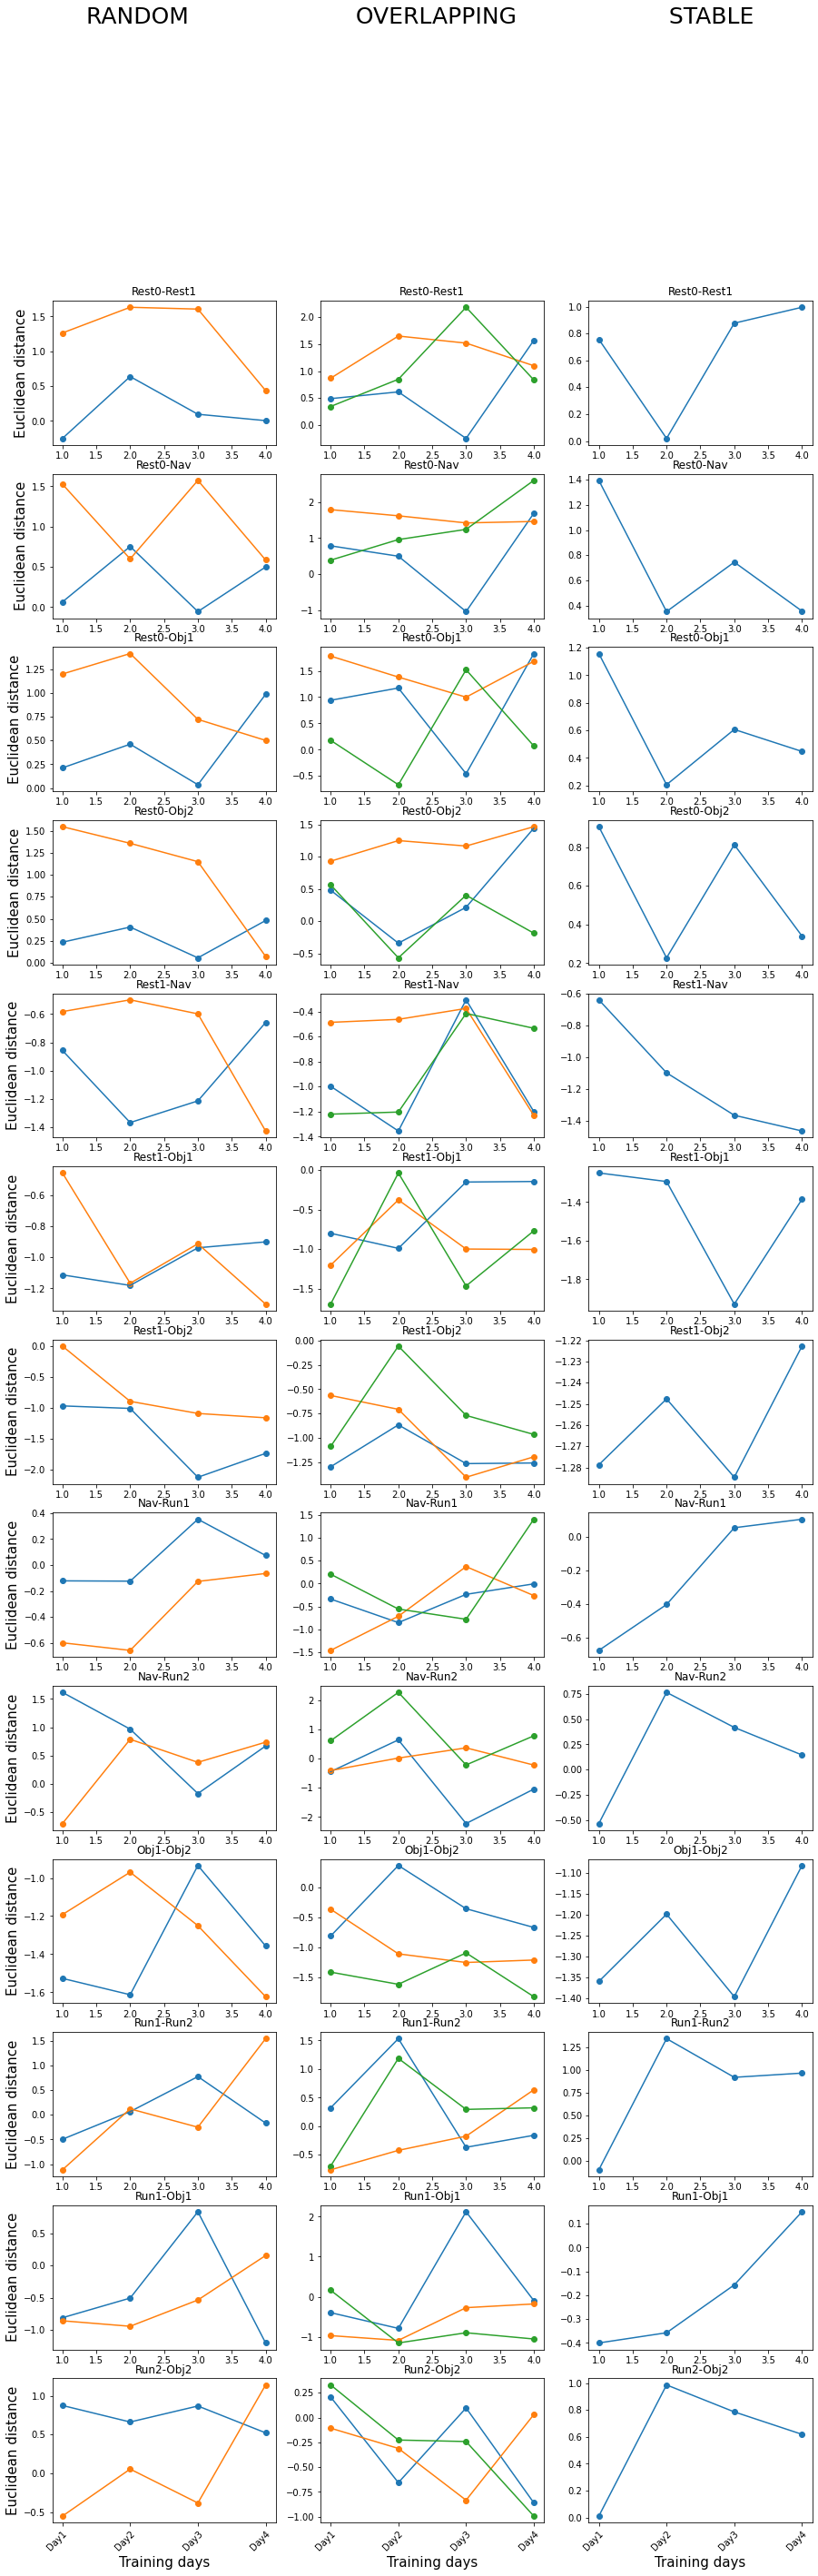

In [11]:
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(13,3)
labels = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2',
          'Rest1-Nav','Rest1-Obj1','Rest1-Obj2','Nav-Run1', 'Nav-Run2','Obj1-Obj2',
          'Run1-Run2','Run1-Obj1','Run2-Obj2']

evolution_list = []
for condition in range(3):
    for mouse in range(len(distance_list[condition])):
        evolution = np.zeros((4,13))
        for day in range(len(distance_list[condition][mouse])):
                
            evolution[day][0] = distance_list_z[condition][mouse][day][0,1]
            evolution[day][1] = distance_list_z[condition][mouse][day][0,2]
            evolution[day][2] = distance_list_z[condition][mouse][day][0,3]
            evolution[day][3] = distance_list_z[condition][mouse][day][0,4]    

            evolution[day][4] = distance_list_z[condition][mouse][day][1,2]
            evolution[day][5] = distance_list_z[condition][mouse][day][1,3]
            evolution[day][6] = distance_list_z[condition][mouse][day][1,4]

            evolution[day][7] = distance_list_z[condition][mouse][day][2,5]
            evolution[day][8] = distance_list_z[condition][mouse][day][2,6] 

            evolution[day][9] = distance_list_z[condition][mouse][day][3,4]
            evolution[day][10] = distance_list_z[condition][mouse][day][5,6]

            evolution[day][11] = distance_list_z[condition][mouse][day][3,5]
            evolution[day][12] = distance_list_z[condition][mouse][day][4,6]
            
            
        for i in range(13):
            axes[i,condition].set_title(labels[i])
            axes[i,condition].scatter([1,2,3,4],evolution[:,i])
            axes[i,condition].plot([1,2,3,4],evolution[:,i])   
            #axes[i,j].legend(labels[i*3+j])
            if condition == 0:
                axes[i,condition].set_ylabel('Euclidean distance', fontsize = 15)
            
            #axes[i,condition].set_ylim([0, 0.07])

        axes[i,condition].set_xlabel('Training days', fontsize = 15)
        x_pos = np.arange(1,5)
        axes[i,condition].set_xticks(x_pos)
        axes[i,condition].set_xticklabels(x_axes)
        plt.setp(axes[i,condition].get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

fig.tight_layout()
fig.set_size_inches(15,45)
fig.suptitle('RANDOM                       OVERLAPPING                     STABLE' , fontsize = 25)
#figure_name = figure_path +'distance_evolution_events_all_mice'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'new.png'

figure_name = figure_path +'distance_evolution_z_score_events_all_mice'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

fig.savefig(figure_name)    

